In [1]:
from __future__ import print_function                                                                                                                                
import sys
import os
import gc
from copy import deepcopy
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as LA
import scipy.sparse as sp
import scipy.sparse.linalg
from modules.convert_parameters import get_kp_model, angstrom_par
from modules.kp_model.kp_model import kp_model
import modules.axial_approximation.axial_kane_model as akm
from modules.kp_model.utils import kp_from_sympy, getpath, calcEpath, getdist, sigma
from modules.kp_model.tb_model import tb_model
from modules.wire import wire_factory
from IPython.display import display, Math, Latex
import sympy
sympy.init_printing()

In [2]:
## ------------------ wire parameters ----------------------
diameter = 400   # in Angstrom
nlayer = 40      # how many layers form the wire, for discretization
Vd   = 0.3e-3    # electric field, in eV/Angstrom
Bs   = 0.5       # scalar value of magnetic field
Bv  = np.array([1.,1.,1.])
Bv /= LA.norm(Bv) # axial direction of the wire
tiltE  = 0/360*2*np.pi # angle of electric field to y-axis
tiltB  = 0/360*2*np.pi # angle of magnetic field to Bv (always perpendicular to y-axis)

latc=diameter/nlayer/np.cos(np.arctan2(1,np.sqrt(2))) # lattice constant used for discretization
a_new = latc*np.array([[0,-1,0],[0,0,-1],[1,1,1]])    # more convinient unit cell for 111 direction
nv  = np.cross(a_new[2],[1,0,0])                      
nv /= LA.norm(nv)
ex = nv                                               # x-direction
ey = np.cross(nv,Bv)                                  # y-directon
bv = np.cos(tiltB)*Bv+np.sin(tiltB)*ex                # direction of magnetic field calculated from tiltB
par = angstrom_par(B=Bs*bv,gamma_0=5,material='InSb')    
par

{hbar: 6.5821195139999995e-15,
 m_0: 5.685630060215049e-30,
 'E_0': 0.237,
 'E_v': -0.237,
 mu_B: 5.7883818012e-05,
 'gamma_2': 1.4659500199068489,
 'gamma_0': 5,
 'P': 9.0250425806218111,
 'kappa': 0.56595001990684857,
 'gamma_1': 7.0319000398136993,
 'g': -5.0362923252131822,
 'gamma_3': 2.6659500199068482,
 'B_y': 0.28867513459481292,
 'Delta': 0.81,
 'B_x': 0.28867513459481292,
 'epsilon': 16.8,
 'B_z': 0.28867513459481292}

In [18]:
## ------------------- kp model -------------------                                                                                                                                                                                                     
kp = get_kp_model(par=par)

In [6]:
## ------------------- make wire -----------------                                                                                                                   
ex, ey, center, wire_kpd = wire_factory(kp, diameter, nlayer, shape='hexagonal')

## add electromagnetic potential
Av  = np.cross(Bs*bv,ey)
vector_potential = lambda pos: Av*np.dot(ey,pos)
Ev = np.cos(tiltE)*ey+np.sin(tiltE)*ex
scalar_potential = lambda pos: Vd*(np.dot(pos,Ev)-np.dot(center,Ev))
wire_kpd.add_vector_potential(vector_potential)
wire_kpd.add_scalar_potential(scalar_potential)

S_op = sp.kron(sp.eye(wire_kpd.norb//kp.N),                # spin-operator for sign of g-factor
               Bv[0]*LA.block_diag(sigma.x,np.zeros((6,6)))+
               Bv[1]*LA.block_diag(sigma.y,np.zeros((6,6)))+
               Bv[2]*LA.block_diag(sigma.z,np.zeros((6,6))))


7/8


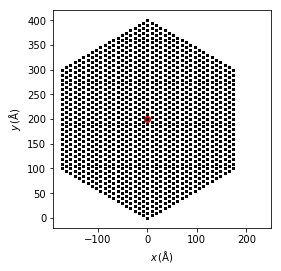

In [7]:
##  -------------------- plot crosssection  --------------------                                                                                                     
plt.figure()
plt.plot(np.dot(ex,center),np.dot(ey,center),'ro')
plt.plot([np.dot(ex,pos) for pos in wire_kpd.lat.p],[np.dot(ey,pos) for pos in wire_kpd.lat.p],'k.',mec='none')
plt.axis('square')
plt.xlabel(r'$x\,(\mathrm{\AA})$')
plt.ylabel(r'$y\,(\mathrm{\AA})$')
plt.show()

In [8]:
##  -------------------- solve wire  --------------------                                                                                                     
nsparse = min(20,wire_kpd.norb-2)
E,V  = sp.linalg.eigsh(sp.csc_matrix(wire_kpd.H([0,0,0],sparse=True)),k=nsparse,tol=1e-6,sigma=0)
gc.collect()

log = E > -80.e-3
E = E[log]
V = V[:,log]
ind = np.argsort(E)
E = E[ind]
V = V[:,ind]
S = np.diag(np.dot(V.T.conj(), S_op.dot(V))).real

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

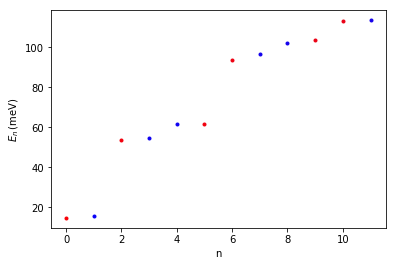

In [9]:
## -------------------- show energy levels -------------------- 
gfactors = np.sign(np.diff(S)[:12:2])*np.diff(E)[:12:2]/LA.norm(Bs)/5.788382e-5
display(Math('g = '+', '.join('{:0.2f}'.format(gi) for gi in gfactors)))
display(Latex('$\Delta E_1 = {:0.2f}\,$meV'.format((E[4]-E[2])*1e3)))
display(Latex('$\Delta E_2 = {:0.2f}\,$meV'.format((E[8]-E[6])*1e3)))

plt.figure()
S1c = (S+1.0001)/2.0002
for i in range(12):
    plt.plot(i,1e3*E[i],'.',color=(S1c[i],0,1-S1c[i]))
plt.ylabel(r'$E_n\,(\mathrm{meV})$')
plt.xlabel(r'n')
plt.show()

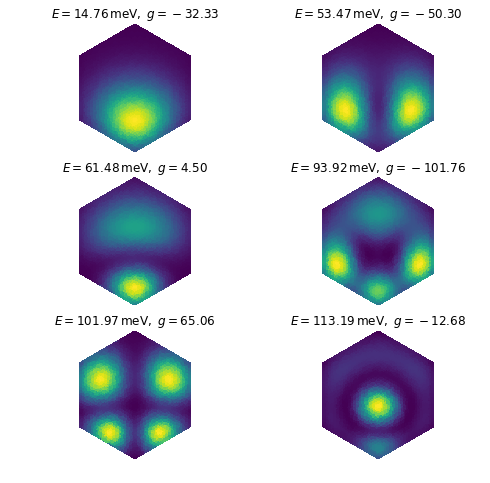

In [13]:
##  -------------------- plot wavefunction  --------------------  
fig, axes = plt.subplots(figsize=(8,8),nrows=3,ncols=2, sharey=True,sharex=True)
x,y = np.array([np.dot(ex,pos) for pos in wire_kpd.lat.p]),np.array([np.dot(ey,pos) for pos in wire_kpd.lat.p])

for i,nE in enumerate(range(0,12,2)):
    z = np.abs(V[:,nE])**2                                                                                                    
    # make elements unique                                                                                                                                           
    unique_weights = {}
    for xi,yi,zi in zip(x,y,z):
        xi = np.round(xi,8)
        yi = np.round(yi,8)
        try:
            unique_weights[(xi,yi)] += zi
        except:
            unique_weights.update({(xi,yi) : zi})
    pos = []
    weights = []
    for key, value in unique_weights.items():
        pos.append(key)
        weights.append(value)
    pos     = np.array(pos)
    weights = np.array(weights)

    ax = axes[nE//4,(nE//2)%2]
    c = ax.tripcolor(pos[:,0],pos[:,1],weights)
    c.set_rasterized(True)
    ax.axis('equal')
    ax.set_xlim([np.min(pos[:,0]),np.max(pos[:,0])])
    ax.set_ylim([np.min(pos[:,1]),np.max(pos[:,1])])
    ax.axis('off')
    ax.set_title('$ E = {0:.2f}\,\mathrm{{meV}},\ g = {1:.2f}$'.format(1e3*E[nE],gfactors[nE//2]))
plt.show()

# Dispersion

In [14]:
##  -------------------- calculate eigenvalues  --------------------                                                                                                       
nsteps = 50                                                                                                                                                       
nsparse = min(40,wire_kpd.norb-2)                                                                                                                                  
path = 0.01*getpath([[0,0,0],Bv],nsteps)                                                                                                                                                                                                            
dist = getdist(path)                                                                                                                                                                                                                                                                                                                                                                                                                      
E,V  = calcEpath(path,wire_kpd,verbose=True,give_states=True,nsparse=nsparse,modelargs=dict(sparse=True),solverargs=dict(tol=1e-4,sigma=0))   


50/51


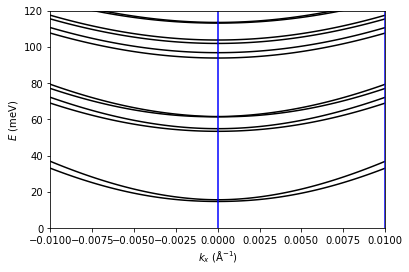

In [15]:
##  -------------------- plot dispersion --------------------
nE = 12
E1 = np.zeros((len(E),nE))                                                                                                                                       
for i, e in enumerate(E):    
    e1 = np.sort(e)
    e1 = e1[e1 > -80e-3]
    E1[i] = e1[:nE]                                                                                 


plt.figure()
plt.plot(dist,1e3*E1,'k-')
plt.plot(-dist,1e3*E1,'k-') 
for x in dist[::nsteps]:                                                                                                                                           
    plt.axvline(x,color='b')                                                                                                                                       
plt.xlim([-dist[-1],dist[-1]])                                                                                                                                       
plt.ylim([0.,120.])                                                                                                                                                                                                                                                                                                  
plt.xlabel(r'$k_x\ (\mathrm{\AA}^{-1})$')                                                                                                                          
plt.ylabel(r'$E\ \mathrm{(meV)}$')  
plt.show()

# Angle dependence

In [20]:
alpha_list = np.linspace(0, 90, 19)
Bs = 0.2
gfactor_list = []

for alpha in alpha_list:
    print(alpha)
    tiltB = alpha/360*2*np.pi
    bv = np.cos(tiltB)*Bv+np.sin(tiltB)*ex  
    par = angstrom_par(B=Bs*bv,gamma_0=5,material='InSb') 
    kp = get_kp_model(par=par)
    ex, ey, center, wire_kpd = wire_factory(kp, diameter, nlayer, shape='hexagonal')
    Av  = np.cross(Bs*bv,ey)
    vector_potential = lambda pos: Av*np.dot(ey,pos)
    wire_kpd.add_vector_potential(vector_potential)
    E,V  = sp.linalg.eigsh(sp.csc_matrix(wire_kpd.H([0,0,0],sparse=True)),k=nsparse,tol=1e-6,sigma=0)
    gc.collect()
    log = E > -80.e-3
    E = E[log]
    V = V[:,log]
    ind = np.argsort(E)
    E = E[ind]
    V = V[:,ind]
    S = np.diag(np.dot(V.T.conj(), S_op.dot(V))).real
    gfactor_list.append(np.sign(np.diff(S)[:12:2])*np.diff(E)[:12:2]/LA.norm(Bs)/5.788382e-5)

0.0

7/8
5.0

7/8
10.0

7/8
15.0

7/8
20.0

7/8
25.0

7/8
30.0

7/8
35.0

7/8
40.0

7/8
45.0

7/8
50.0

7/8
55.0

7/8
60.0

7/8
65.0

7/8
70.0

7/8
75.0

7/8
80.0

7/8
85.0

7/8
90.0

7/8


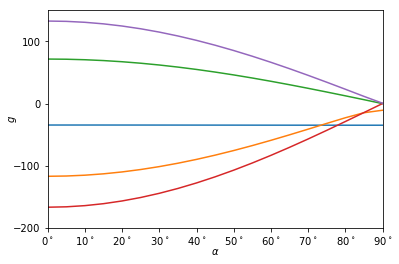

In [35]:
g = np.array(gfactor_list)

plt.figure()
for i in range(5):
    plt.plot(alpha_list,g[:,i])
plt.xlim([alpha_list[0], alpha_list[1]])
plt.ylim([-200,150])
plt.xlabel(r'$\alpha$',labelpad=0)
plt.xticks([0,10,20,30,40,50,60,70,80,90],['0$^\circ$','10$^\circ$','20$^\circ$','30$^\circ$','40$^\circ$','50$^\circ$','60$^\circ$','70$^\circ$','80$^\circ$','90$^\circ$'])
plt.yticks([-200,-100,0,100])
plt.ylabel(r'$g$',labelpad=-6)
plt.show()

# Electric field dependence

In [66]:
Vd_list = np.linspace(0, 1.e-3, 11)
Bs = 0.2
gfactor_list = []

par = angstrom_par(B=Bs*Bv,gamma_0=5,material='InSb') 
kp = get_kp_model(par=par)
ex, ey, center, wire_kpd = wire_factory(kp, diameter, nlayer, shape='hexagonal')
Av  = np.cross(Bs*Bv,ey)
vector_potential = lambda pos: Av*np.dot(ey,pos)
wire_kpd.add_vector_potential(vector_potential)

for Vd in Vd_list:
    print(Vd)
    wire1 = deepcopy(wire_kpd)
    Ev = np.cos(tiltE)*ey+np.sin(tiltE)*ex
    scalar_potential = lambda pos: Vd*(np.dot(pos,Ev)-np.dot(center,Ev))
    wire1.add_scalar_potential(scalar_potential)
    E,V  = sp.linalg.eigsh(sp.csc_matrix(wire1.H([0,0,0],sparse=True)),k=nsparse,tol=1e-6,sigma=0)
    gc.collect()
    log = E > -80.e-3
    E = E[log]
    V = V[:,log]
    ind = np.argsort(E)
    E = E[ind]
    V = V[:,ind]
    S = np.diag(np.dot(V.T.conj(), S_op.dot(V))).real
    gfactor_list.append(np.sign(np.diff(S)[:12:2])*np.diff(E)[:12:2]/LA.norm(Bs)/5.788382e-5)


7/8
0.0
0.0001
0.0002
0.0003
0.0004
0.0005
0.0006
0.0007
0.0008
0.0009
0.001


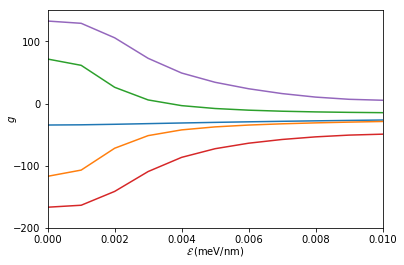

In [70]:
g = np.array(gfactor_list)

plt.figure()
for i in range(5):
    plt.plot(10*np.array(Vd_list),g[:,i])
plt.xlim([0, 10.e-3])
plt.ylim([-200,150])
plt.xlabel(r'$\mathcal{E}\,(\mathrm{meV/nm})$',labelpad=0)
plt.yticks([-200,-100,0,100])
plt.ylabel(r'$g$',labelpad=-6)
plt.show()